In [1]:
!pip install nltk
!pip install gensim

# Theory

**CBOW (Continuous Bag of Words) and Skip-Gram** are two different architectures used in Word2Vec for learning word embeddings, but they differ in how they approach the prediction task and handle the relationship between words.

### 1. **CBOW (Continuous Bag of Words)**

- **Objective**: Predict a target word (center word) based on its surrounding context words.
- **Input**: Context words (the words surrounding the target word).
- **Output**: The target word (the center word).
  
#### How CBOW works:
- It takes a context window of words around the target word and tries to predict the target word based on the context.
- The context words are treated as a "bag of words," meaning their order does not matter.
  
#### Example:
In the sentence "`I enjoy walking in the park`" with a window size of 2, if we take "walking" as the center word, the context words will be `["I", "enjoy", "in", "the"]`. The model will try to predict the word "walking" based on these surrounding words.

#### Architecture:
- The embeddings of all context words are averaged and passed through a hidden layer to predict the target word.
- It uses a simple neural network with one hidden layer.

#### Pros:
- Faster to train since it aggregates context words into one vector and performs only one prediction.
- Suitable when the dataset is large and when context words carry more information than the center word.

#### Cons:
- It averages the context word embeddings, which may lose subtle differences between individual words in the context.
  
---

### 2. **Skip-Gram Model**

- **Objective**: Predict context words (surrounding words) based on a given target word (center word).
- **Input**: The target word (center word).
- **Output**: The surrounding context words.

#### How Skip-Gram works:
- For each target word, it tries to predict the surrounding context words within a given window size.
- Each center word is associated with multiple training samples, where it attempts to predict each of its neighboring words.

#### Example:
For the same sentence "`I enjoy walking in the park`" with the word "walking" as the center, Skip-Gram will attempt to predict the surrounding words `["I", "enjoy", "in", "the"]` from the center word "walking".

#### Architecture:
- A simple neural network where the input is the center word, which is passed through an embedding layer to predict each context word independently.
  
#### Pros:
- It works well for smaller datasets and rare words since it generates multiple predictions from each center word.
- Better for capturing semantic relationships between words, especially for rare words.

#### Cons:
- It takes longer to train compared to CBOW because it predicts multiple context words for each input center word.

---

### **Key Differences**:

| Aspect                | **CBOW**                                     | **Skip-Gram**                                |
|-----------------------|----------------------------------------------|---------------------------------------------|
| **Prediction Type**    | Predict target word from context words       | Predict context words from target word      |
| **Input**              | Context words                               | Target word (center word)                   |
| **Output**             | Target word (center word)                    | Context words                               |
| **Training Speed**     | Faster to train                              | Slower, especially for large datasets       |
| **Best for**           | Large datasets and common words              | Small datasets, rare words, and detailed word relationships |
| **Representation**     | Averages embeddings of context words         | Directly predicts multiple context words for each center word |
| **Memory Efficiency**  | More efficient as it averages context words  | Less efficient since it predicts multiple context words |

---

### **When to Use CBOW vs Skip-Gram**:

- **CBOW** is preferred when:
  - The dataset is large.
  - You want a fast training process.
  - Context carries more information than individual center words.
  
- **Skip-Gram** is preferred when:
  - The dataset is small, and you need to capture the relationships between individual words, especially rare words.
  - You want high-quality embeddings that capture finer word semantics.

### Summary:

- **CBOW** predicts the center word based on the surrounding context, and it works faster but may lose some finer semantic details.
- **Skip-Gram** predicts surrounding context words from a center word and captures more detailed word relationships but at the cost of longer training time.

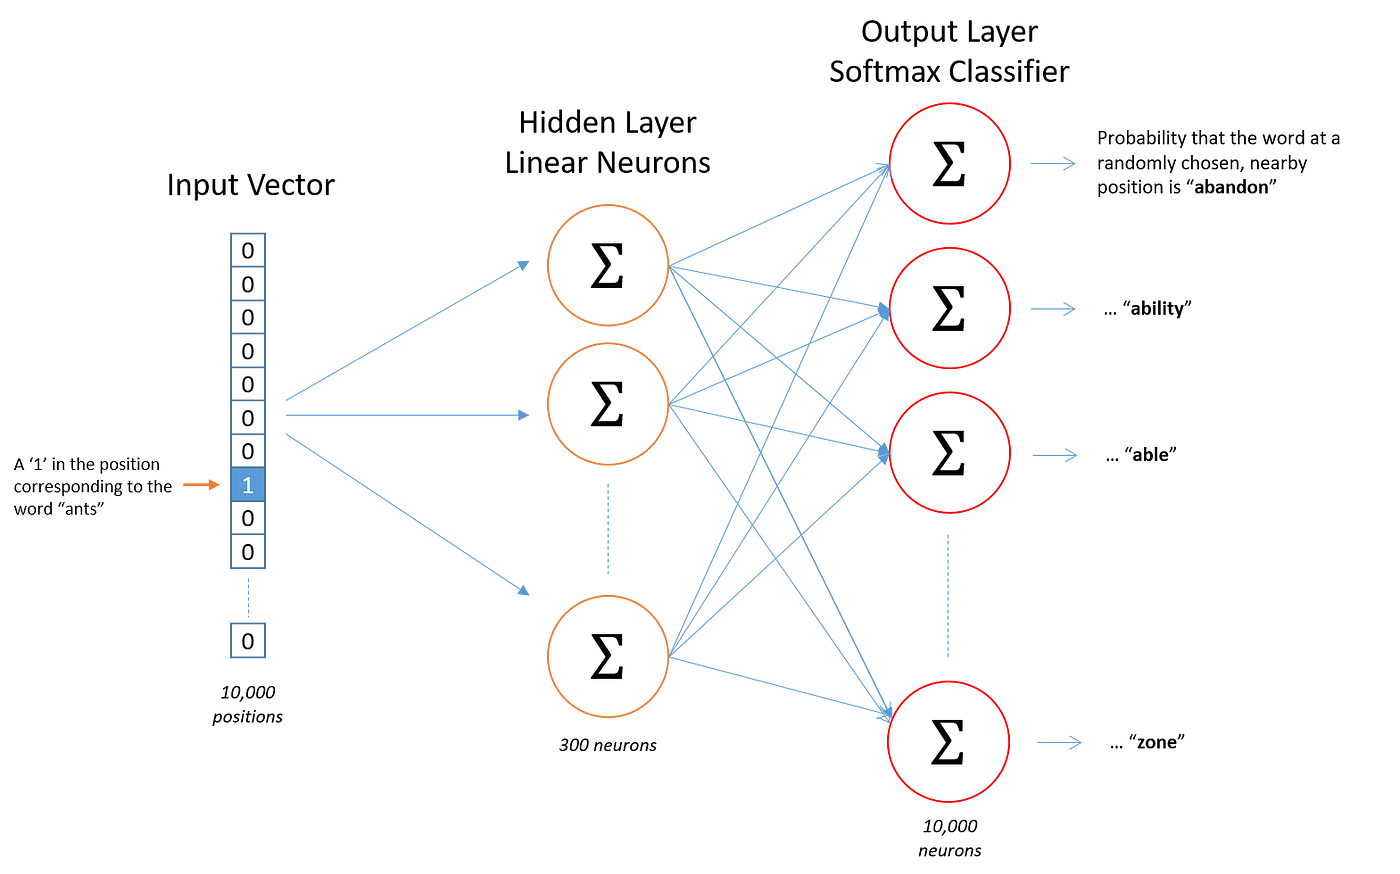

# Import Libraries

In [2]:
import pandas as pd

import nltk
from nltk.corpus import brown
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
 
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

# Convert to document corpus

In [3]:
df = pd.read_csv("data/TwitterDataset.csv", encoding='latin')

In [4]:
df.head()

,File Name,Caption,LABEL
0,1.txt,How I feel today #legday #jelly #aching #gym,negative
1,10.txt,@ArrivaTW absolute disgrace two carriages from...,negative
2,100.txt,This is my Valentine's from 1 of my nephews. I...,positive
3,1000.txt,betterfeelingfilms: RT via Instagram: First da...,neutral
4,1001.txt,Zoe's first love #Rattled @JohnnyHarper15,positive


In [5]:
df['Caption']

0           How I feel today #legday #jelly #aching #gym 
1       @ArrivaTW absolute disgrace two carriages from...
2       This is my Valentine's from 1 of my nephews. I...
3       betterfeelingfilms: RT via Instagram: First da...
4              Zoe's first love #Rattled @JohnnyHarper15 
                              ...                        
4864    OMG. Well done #Eskom! 'Man dies during #LoadS...
4865    Feelin' the love in here! #ValentinesDay #caring 
4866                        #blue #eyes can't be #beaten 
4867                LA CHUCHA LOUUU TE CHUPO LOS OJOS..! 
4868    #colorsplash_bw #zealous Remedios #herbales y ...
Name: Caption, Length: 4869, dtype: object

# Preprocess

In [6]:
def remove_usernames(text):
    return re.sub(r'@\w+', '', text)

def remove_hashtags(text):
    return re.sub(r'#', '', text)

def clean_text(text):
    # Removing URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Removing special characters and numbers
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    # Removing extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_text(text):
    return word_tokenize(text)

def case_folding(text):
    return text.lower()

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def stem_tokens(tokens):
    stemmer = PorterStemmer()
    return [stemmer.stem(word) for word in tokens]

def preprocess_text(text):
    text = remove_usernames(text)
    text = remove_hashtags(text)
    text = clean_text(text)
    text = case_folding(text)
    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    # tokens = stem_tokens(tokens)
    return ' '.join(tokens)

# Preprocess

In [7]:
df['Caption'] = df['Caption'].apply(preprocess_text)

# Make document corpus

In [8]:
data = []
for doc in df['Caption'].to_list():
    data.append(doc.split())

In [9]:
data[:5]

[['feel', 'today', 'legday', 'jelly', 'aching', 'gym'],
 ['absolute',
  'disgrace',
  'two',
  'carriages',
  'bangor',
  'half',
  'way',
  'standing',
  'room',
  'disgraced'],
 ['valentine',
  'nephews',
  'elated',
  'sometimes',
  'little',
  'things',
  'biggest',
  'best',
  'things'],
 ['betterfeelingfilms',
  'rt',
  'via',
  'instagram',
  'first',
  'day',
  'filming',
  'powerless',
  'back'],
 ['zoe', 'first', 'love', 'rattled']]

# Train Word2vec

In [10]:
vector_size = 50

In [11]:
model = Word2Vec(
    sentences = data,
    vector_size = vector_size,
    window = 5,
    epochs = 50,
)

# Save and Load

In [12]:
model.save('model/brown_w2vec.model')
model=Word2Vec.load("model/brown_w2vec.model")

# Predict

In [13]:
# Vector for word love
print("Vector for love:")
print(model.wv["happy"])
print()

Vector for love:
[ 0.4073109   2.0885444  -2.074908   -0.0689896   0.73622674 -1.6543517
 -0.24235043  1.6352818  -1.5966952   0.41067716 -0.4073422  -0.55124205
 -0.46592072 -0.6569793   1.3011307   0.5688373   1.1839088  -0.6470256
 -1.2388543  -1.097739   -0.64523053  0.48914522 -0.16257745 -1.8214025
  1.4167027  -0.64744735 -0.21102397 -0.1161886   0.27035406  0.8944926
  1.7013062  -0.37361735  0.1602382   1.3787793  -1.5829364  -0.7252215
  1.56556    -0.33620405  0.5048899  -0.55470514 -0.07084382  0.80620396
  0.9484556   1.0779029   0.9503137   1.1480964   0.9307943  -1.4035991
 -0.2820754   1.2620511 ]



In [14]:
# Finding most similar words
print("3 words similar to love")
words = model.wv.most_similar("love", topn=8)
for word in words:
    print(word)
print()
 

3 words similar to love
('smile', 0.8492212891578674)
('miss', 0.8276190161705017)
('positive', 0.8030020594596863)
('relationship', 0.8003309965133667)
('calm', 0.8000233769416809)
('thoughts', 0.7967272400856018)
('lots', 0.7909608483314514)
('felt', 0.7891524434089661)



# Visualize

In [15]:
words = ["room", "talent", "happy", "love", "bro"]

# Transform with PCA

In [16]:
X = model.wv[words]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

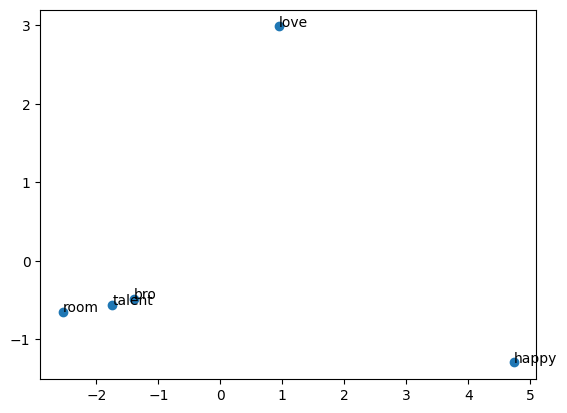

In [17]:
pyplot.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [20]:
print(model.wv["goalklaassen"])

KeyError: "Key 'goalklaassen' not present"

In [21]:
# add new words to vocab
docs = [['potoatoes', 'and', 'goalklaassen', 'champions']]   
data.extend(docs)
model = Word2Vec(data, vector_size = vector_size, window = 5, min_count = 1, workers = 4)
  
model.train(docs, total_examples = len(docs), epochs = 10)

(40, 40)

In [22]:
print(model.wv["goalklaassen"])

[ 0.01705208 -0.00867404 -0.01524243 -0.01717256 -0.00495346  0.00042414
  0.00683894 -0.01140402 -0.02394959 -0.01299695  0.00679863 -0.00606901
  0.0074784   0.00141342 -0.01591261  0.00392219 -0.00948964  0.01182002
  0.00968911 -0.02093493 -0.01911795  0.01906254  0.01022322 -0.01691209
 -0.01268577 -0.013448    0.0106642  -0.00585749 -0.01928714 -0.00456952
  0.01421521  0.01573778 -0.00940986 -0.01839725  0.01076758 -0.01295922
 -0.00535153  0.00795007 -0.00982942  0.01370207  0.00861201 -0.02034806
  0.01527724 -0.00965971  0.0234277   0.00922291  0.00392176 -0.01524784
 -0.01101519 -0.01210928]


In [23]:
model.save('model/w2vec_sentiment.model')

# Visualization in 3D

In [24]:
import numpy as np
import csv

In [25]:
word_vectors = model.wv
words = list(word_vectors.index_to_key)
vectors = np.array([word_vectors[word] for word in words])

# Save words

In [26]:
# Filepath for saving the metadata (words)
metadata_file_path = "model/w2vec_metadata.tsv"

# Save words to metadata file
with open(metadata_file_path, 'w', newline='', encoding='utf-8') as metadata_file:
    for word in words:
        metadata_file.write(word + '\n')


# Save Vectors

In [27]:
# Filepath for saving the vectors
vectors_file_path = "model/w2vec_vectors.tsv"

# Save vectors to the vectors file
with open(vectors_file_path, 'w', newline='', encoding='utf-8') as vectors_file:
    writer = csv.writer(vectors_file, delimiter='\t')
    
    # Write each vector to the file
    for vector in vectors:
        writer.writerow(vector)


# Visualize

https://projector.tensorflow.org/

# Embeding Types

Here are some of the most famous word embeddings used in natural language processing (NLP) and machine learning tasks:

### 1. **Word2Vec (2013)**
   - **Developed by**: Google (Tomas Mikolov et al.)
   - **Key Feature**: Predicts word embeddings using either the Continuous Bag of Words (CBOW) or Skip-Gram model.
   - **Usage**: Efficient for capturing syntactic and semantic word relationships.
   - **Applications**: Text classification, sentiment analysis, machine translation, etc.
   - **Pre-trained Models**: Google News pre-trained Word2Vec vectors (3 million words, 300 dimensions).

### 2. **GloVe (Global Vectors for Word Representation) (2014)**
   - **Developed by**: Stanford (Jeffrey Pennington et al.)
   - **Key Feature**: Trains word embeddings using global word-word co-occurrence statistics.
   - **Usage**: Captures both local (contextual) and global (corpus-wide) statistics for word relationships.
   - **Applications**: Text generation, question answering, and text classification.
   - **Pre-trained Models**: Available on Common Crawl, Wikipedia, and Twitter datasets.

### 3. **FastText (2016)**
   - **Developed by**: Facebook AI Research (FAIR)
   - **Key Feature**: Unlike Word2Vec, FastText represents each word as a bag of character n-grams, making it good for capturing morphological features of words.
   - **Usage**: Handles out-of-vocabulary (OOV) words by creating embeddings for rare and unseen words.
   - **Applications**: Text classification, named entity recognition, machine translation.
   - **Pre-trained Models**: Available for 157 languages on Wikipedia, Common Crawl, and Web Crawl datasets.

### 4. **ELMo (Embeddings from Language Models) (2018)**
   - **Developed by**: Allen Institute for AI
   - **Key Feature**: Contextualized word embeddings, meaning the embedding of a word changes based on the surrounding words (context).
   - **Usage**: Generates different embeddings for polysemous words based on their context.
   - **Applications**: Named entity recognition, coreference resolution, and question answering.
   - **Pre-trained Models**: Available for several tasks, with embeddings derived from bidirectional LSTM-based models.

### 5. **BERT (Bidirectional Encoder Representations from Transformers) (2018)**
   - **Developed by**: Google AI (Jacob Devlin et al.)
   - **Key Feature**: Pre-trained deep bidirectional transformer model that captures context from both directions (left-to-right and right-to-left).
   - **Usage**: Generates contextualized word embeddings and allows fine-tuning on various downstream NLP tasks.
   - **Applications**: Question answering, text classification, text summarization, and more.
   - **Pre-trained Models**: BERT-base, BERT-large, multilingual BERT, and domain-specific BERT models (e.g., BioBERT, SciBERT).

### 6. **GPT (Generative Pre-trained Transformer) (2018)**
   - **Developed by**: OpenAI
   - **Key Feature**: Uses a unidirectional transformer-based language model trained on a large corpus.
   - **Usage**: Focuses on generating high-quality language sequences and text embeddings.
   - **Applications**: Text generation, machine translation, chatbot development, etc.
   - **Pre-trained Models**: GPT-2, GPT-3, GPT-4, with billions of parameters for state-of-the-art language understanding.

### 7. **Transformer-XL (2019)**
   - **Developed by**: Google AI Brain Team
   - **Key Feature**: Introduces recurrence mechanisms to transformers, allowing the model to capture long-term dependencies beyond fixed-length contexts.
   - **Usage**: Handles longer sequences than traditional transformers, making it effective for long text generation.
   - **Applications**: Text generation, language modeling, and text understanding tasks.
   - **Pre-trained Models**: Available through open-source implementations.

### 8. **RoBERTa (Robustly Optimized BERT Pretraining Approach) (2019)**
   - **Developed by**: Facebook AI Research (FAIR)
   - **Key Feature**: Builds on BERT by training longer on more data, using a dynamic masking strategy.
   - **Usage**: Provides improved performance over BERT for various NLP tasks.
   - **Applications**: Text classification, sequence labeling, text generation, etc.
   - **Pre-trained Models**: RoBERTa-base, RoBERTa-large, domain-specific models like LegalBERT and ClinicalBERT.

### 9. **T5 (Text-To-Text Transfer Transformer) (2019)**
   - **Developed by**: Google Research
   - **Key Feature**: Treats every NLP task as a text-to-text problem, meaning it converts all tasks (e.g., classification, summarization) into generating text outputs.
   - **Usage**: Produces word embeddings while being capable of performing any text-based NLP task.
   - **Applications**: Text summarization, translation, question answering, and classification.
   - **Pre-trained Models**: T5-base, T5-large, T5-3B, T5-11B.

### 10. **ALBERT (A Lite BERT) (2019)**
   - **Developed by**: Google Research
   - **Key Feature**: A more memory-efficient version of BERT, with parameter-sharing across layers and factorized embedding.
   - **Usage**: Efficient for large-scale NLP tasks where memory and speed are critical.
   - **Applications**: Similar to BERT, used for text classification, question answering, and sentence encoding.
   - **Pre-trained Models**: ALBERT-base, ALBERT-large.

### 11. **XLNet (2019)**
   - **Developed by**: Google AI and CMU
   - **Key Feature**: Combines the advantages of BERT and autoregressive models, improving language modeling performance.
   - **Usage**: Provides better context-aware word embeddings than traditional models.
   - **Applications**: Text classification, sentence encoding, and text generation tasks.
   - **Pre-trained Models**: XLNet-base, XLNet-large.

### 12. **Flair (2018)**
   - **Developed by**: Zalando Research
   - **Key Feature**: Provides contextual string embeddings based on character-level language models.
   - **Usage**: Contextual embeddings are based on a sequence of characters, capturing semantic meaning for words in context.
   - **Applications**: Named entity recognition, sentiment analysis, and part-of-speech tagging.
   - **Pre-trained Models**: Available for multiple languages, and can be combined with other embeddings like GloVe and BERT.

These models have had a significant impact on various natural language processing tasks, enabling more accurate and efficient representations of words and context in text.